In [1]:
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
from torchvision.transforms import v2
import sys

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


These are my settings and my model and I am only getting 51 % test accuracy

def get_transforms(random_crop=False, horizontal_flip=False,
                    translation=False, standardNormalize=False,
                      mu=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Get transformation pipeline for training and test datasets.

    Args:
        random_crop (int): Padding size to apply random cropping.
        horizontal_flip (float): Probability to apply random horizontal flip.
        translation (tuple): Maximum absolute fraction for horizontal and vertical translations.
        standardNormalize (bool): Whether to apply normalization.
        mu (tuple): Mean for normalization.
        std (tuple): Standard deviation for normalization.

    Returns:
        torchvision.transforms.Compose: Transformation pipeline.
    """
    transform_list = []
    if random_crop:
        transform_list.append(v2.RandomCrop(random_crop, padding=4))
    if horizontal_flip:
        transform_list.append(v2.RandomHorizontalFlip(horizontal_flip))
    if translation:
        transform_list.append(v2.RandomAffine(degrees=0, translate=translation))
    
    transform_list.append(v2.ToTensor())
    
    if standardNormalize:
        transform_list.append(v2.Normalize(mu, std))
    
    return v2.Compose(transform_list)


# Training
def fit(model, dataLoader, criterion, optimizer, num_epochs):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataLoader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move data to GPU
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0


#Evaluation
def evaluate_model(model, testloader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

# Loading Optimiser
def create_optimizer(model, lr=0.001, momentum=0.9, weight_decay=0.0):
    return optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)




class Cifar10Model(nn.Module):
    def __init__(self, dropout_rate=0.0, batch_norm=False):
        super(Cifar10Model,self).__init__()
        self.batch_norm = batch_norm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32) if batch_norm else nn.Identity()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64) if batch_norm else nn.Identity()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128) if batch_norm else nn.Identity()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.bn4 = nn.BatchNorm1d(128) if batch_norm else nn.Identity()
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # out = 32,32,32 (channels, height, width)
        x = self.relu(self.bn1(self.conv2(x)))  # out = 32,32,32
        x = self.pool1(x) # out = 32,16,16
        x = self.dropout1(x)
        
        x = self.relu(self.bn2(self.conv3(x)))  # out = 64,16,16
        x = self.relu(self.bn2(self.conv4(x))) # out = 64,16,16
        x = self.pool2(x) # out = 64,8,8
        x = self.dropout2(x)
        
        x = self.relu(self.bn3(self.conv5(x))) # out = 128,8,8
        x = self.relu(self.bn3(self.conv6(x))) # out = 128,8,8
        x = self.pool3(x) # out = 128,4,4
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn4(self.fc1(x))) # out = 128
        x = self.dropout4(x)
        x = self.fc2(x) # out = 10
        return self.softmax(x)


# mu = (0.4914, 0.4822, 0.4465)
# std=(0.2023, 0.1994, 0.2010)
#random_crop = 32 # crop size
#horizontal_flip = 0.5 # random flip probability
#translation = (0.1,0.1) # horizontal, vertical
batch_size = 64

train_transform = get_transforms(standardNormalize=True) # Parameters are defaulted to no change. change parameters as wanted
test_transform = get_transforms(standardNormalize=True)

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

model = Cifar10Model(dropout_rate=0.2, batch_norm=False)
Loss = nn.CrossEntropyLoss()
optimizer = create_optimizer(model, lr=0.001, momentum=0.9, weight_decay=0)
n_epochs = 10


fit(model, train_loader, Loss, optimizer, n_epochs)
evaluate_model(model, test_loader)

## E Part

#### Functions

In [2]:
# Transformations

def get_transforms(random_crop=False, horizontal_flip=False,
                    translation=False, standardNormalize=False,
                      mu=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Get transformation pipeline for training and test datasets.

    Args:
        random_crop (int): Padding size to apply random cropping.
        horizontal_flip (float): Probability to apply random horizontal flip.
        translation (tuple): Maximum absolute fraction for horizontal and vertical translations.
        standardNormalize (bool): Whether to apply normalization.
        mu (tuple): Mean for normalization.
        std (tuple): Standard deviation for normalization.

    Returns:
        torchvision.transforms.Compose: Transformation pipeline.
    """
    transform_list = []
    if random_crop:
        transform_list.append(v2.RandomCrop(random_crop, padding=4))
    if horizontal_flip:
        transform_list.append(v2.RandomHorizontalFlip(horizontal_flip))
    if translation:
        transform_list.append(v2.RandomAffine(degrees=0, translate=translation))
    
    transform_list.append(v2.ToTensor())
    
    if standardNormalize:
        transform_list.append(v2.Normalize(mu, std))
    
    return v2.Compose(transform_list)


# Training
def fit(model, dataLoader, criterion, optimizer, num_epochs, CutMix = False, MixUp = False):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(dataLoader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move data to GPU
            optimizer.zero_grad()
            if CutMix:
                inputs, labels_a, labels_b, lam = cutmix(inputs, labels)
                outputs = model(inputs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            elif MixUp:
                inputs, labels_a, labels_b, lam = mixup(inputs, labels)
                outputs = model(inputs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)  
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0


#Evaluation
def evaluate_model(model, testloader):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

# Loading Optimiser
def create_optimizer(model, lr=0.001, momentum=0.9, weight_decay=0.0):
    return optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)


#CutMix augmentation
def cutmix(data, targets, alpha=1.0):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]

    targets = (targets, shuffled_targets, lam)
    return data, targets
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


# MixUp augmentation
def mixup(data, targets, alpha=1.0):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    data = lam * data + (1 - lam) * shuffled_data
    targets = (targets, shuffled_targets, lam)
    return data, targets


#### Loading the Dataset and normalization / transformation

In [3]:
# mu = (0.4914, 0.4822, 0.4465)
# std=(0.2023, 0.1994, 0.2010)
#random_crop = 32 # crop size
#horizontal_flip = 0.5 # random flip probability
#translation = (0.1,0.1) # horizontal, vertical
batch_size = 64

train_transform = get_transforms(standardNormalize=True) # Parameters are defaulted to no change. change parameters as wanted
test_transform = get_transforms(standardNormalize=True)

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

C:\Users\kimambo\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


100%|██████████| 170498071/170498071 [00:02<00:00, 77858372.33it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print('Train: X=%s, Y=(%s)' % (trainset.data.shape, len(trainset.targets)))
print('Test: X=%s, Y=(%s)' % (testset.data.shape, len(testset.targets)))

Train: X=(50000, 32, 32, 3), Y=(50000)
Test: X=(10000, 32, 32, 3), Y=(10000)


#### Test output size


$\text{Output\_size} = \left( \frac{\text{Input\_size} - \text{Kernel\_size} + 2 \times \text{Padding}}{\text{Stride}} \right) + 1$

In [5]:
conv_layer = nn.Conv2d(3, 32, kernel_size=(3, 3), padding=1)

input_tensor = torch.randn(1, 3, 32, 32) # (batchsize, channels, height, width)

output_tensor = conv_layer(input_tensor)

print(output_tensor.shape)

torch.Size([1, 32, 32, 32])


#### One Block VGG

In [6]:
class Cifar10Model_1block(nn.Module):
    def __init__(self):
        super(Cifar10Model_1block,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32*16*16, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x)) # out = 32,32,32 (channels, height, width)
        x = self.relu(self.conv2(x)) # out = 32,32,32
        x = self.pool(x) # out = 32,16,16
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x)) # out = 128
        x = self.fc2(x) # out = 10
        return self.softmax(x)
    


In [7]:
model = Cifar10Model_1block()
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 10

In [8]:
fit(model, train_loader, Loss, optimizer, n_epochs)

[Epoch 1, Batch 100] loss: 2.303
[Epoch 1, Batch 200] loss: 2.302
[Epoch 1, Batch 300] loss: 2.302
[Epoch 1, Batch 400] loss: 2.301
[Epoch 1, Batch 500] loss: 2.301
[Epoch 1, Batch 600] loss: 2.300
[Epoch 1, Batch 700] loss: 2.300
[Epoch 2, Batch 100] loss: 2.298
[Epoch 2, Batch 200] loss: 2.296
[Epoch 2, Batch 300] loss: 2.294
[Epoch 2, Batch 400] loss: 2.292
[Epoch 2, Batch 500] loss: 2.287
[Epoch 2, Batch 600] loss: 2.281
[Epoch 2, Batch 700] loss: 2.266
[Epoch 3, Batch 100] loss: 2.246
[Epoch 3, Batch 200] loss: 2.225
[Epoch 3, Batch 300] loss: 2.210
[Epoch 3, Batch 400] loss: 2.210
[Epoch 3, Batch 500] loss: 2.201
[Epoch 3, Batch 600] loss: 2.198
[Epoch 3, Batch 700] loss: 2.192
[Epoch 4, Batch 100] loss: 2.182
[Epoch 4, Batch 200] loss: 2.173
[Epoch 4, Batch 300] loss: 2.174
[Epoch 4, Batch 400] loss: 2.169
[Epoch 4, Batch 500] loss: 2.154
[Epoch 4, Batch 600] loss: 2.154
[Epoch 4, Batch 700] loss: 2.148
[Epoch 5, Batch 100] loss: 2.135
[Epoch 5, Batch 200] loss: 2.133
[Epoch 5, 

In [ ]:
evaluate_model(model, test_loader)

#### Three Block Baseline

In [ ]:
class Cifar10Model(nn.Module):
    def __init__(self):
        super(Cifar10Model,self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), padding=1)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3,3), padding=1)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3,3), padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(3,3), padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.conv1(x)) # out = 32,32,32 (channels, height, width)
        x = self.relu(self.conv2(x)) # out = 32,32,32
        x = self.pool(x) # out = 32,16,16
        
        x = self.relu(self.conv3(x)) # out = 64,16,16
        x = self.relu(self.conv4(x)) # out = 64,16,16
        x = self.pool(x) # out = 64,8,8
        
        x = self.relu(self.conv5(x)) # out = 128,8,8
        x = self.relu(self.conv6(x)) # out = 128,8,8
        x = self.pool(x) # out = 128,4,4
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x)) # out = 128
        x = self.fc2(x) # out = 10
        return self.softmax(x)

In [ ]:
model = Cifar10Model()
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 2

In [ ]:
fit(model, train_loader, Loss, optimizer, n_epochs)

In [ ]:
evaluate_model(model, test_loader)

#### Full Baseline

In [6]:
class Cifar10Model(nn.Module):
    def __init__(self, dropout_rate=0.0, batch_norm=False):
        super(Cifar10Model,self).__init__()
        self.batch_norm = batch_norm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32) if batch_norm else nn.Identity()
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(64) if batch_norm else nn.Identity()
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(128) if batch_norm else nn.Identity()
        self.dropout3 = nn.Dropout(dropout_rate)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.bn4 = nn.BatchNorm1d(128) if batch_norm else nn.Identity()
        self.dropout4 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))  # out = 32,32,32 (channels, height, width)
        x = self.relu(self.bn1(self.conv2(x)))  # out = 32,32,32
        x = self.pool1(x) # out = 32,16,16
        x = self.dropout1(x)
        
        x = self.relu(self.bn2(self.conv3(x)))  # out = 64,16,16
        x = self.relu(self.bn2(self.conv4(x))) # out = 64,16,16
        x = self.pool2(x) # out = 64,8,8
        x = self.dropout2(x)
        
        x = self.relu(self.bn3(self.conv5(x))) # out = 128,8,8
        x = self.relu(self.bn3(self.conv6(x))) # out = 128,8,8
        x = self.pool3(x) # out = 128,4,4
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn4(self.fc1(x))) # out = 128
        x = self.dropout4(x)
        x = self.fc2(x) # out = 10
        return x


# Test Code (Full Baseline + Dropout)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define the PyTorch model
class Cifar10Model(nn.Module):
    def __init__(self):
        super(Cifar10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Initialize the model, optimizer, and loss function
model = Cifar10Model()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Training loop
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = 100* correct / total
        print(f'Test Accuracy: {test_accuracy:.4f}%')

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50)



Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Loss: 2.3031
Test Accuracy: 0.1000
Epoch 2/50, Loss: 2.3025
Test Accuracy: 0.1237
Epoch 3/50, Loss: 2.3022
Test Accuracy: 0.1530
Epoch 4/50, Loss: 2.3015
Test Accuracy: 0.1924
Epoch 5/50, Loss: 2.2875
Test Accuracy: 0.1859
Epoch 6/50, Loss: 2.0946
Test Accuracy: 0.2870
Epoch 7/50, Loss: 1.9621
Test Accuracy: 0.3370
Epoch 8/50, Loss: 1.8765
Test Accuracy: 0.3540
Epoch 9/50, Loss: 1.7789
Test Accuracy: 0.3839
Epoch 10/50, Loss: 1.6993
Test Accuracy: 0.4131
Epoch 11/50, Loss: 1.6317
Test Accuracy: 0.4447
Epoch 12/50, Loss: 1.5835
Test Accuracy: 0.4718
Epoch 13/50, Loss: 1.5304
Test Accuracy: 0.4808
Epoch 14/50, Loss: 1.4803
Test Accuracy: 0.4942
Epoch 15/50, Loss: 1.4403
Test Accuracy: 0.5147
Epoch 16/50, Loss: 1.4051
Test Accuracy: 0.5345
Epoch 17/50, Loss: 1.3610
Test Accuracy: 0.5511
Epoch 18/50, Loss: 1.3317
Test Accuracy: 0.5509
Epoch 19/50, Loss: 1.3004
Test Accuracy: 0.5709
Epoch 20/50, Loss: 1.

 # Test Code (Full Baseline +  Weight Decay (L2 Regularization))

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Loss: 2.3030
Test Accuracy: 10.0000
Epoch 2/50, Loss: 2.3016
Test Accuracy: 13.5700
Epoch 3/50, Loss: 2.2941
Test Accuracy: 20.0500
Epoch 4/50, Loss: 2.0490
Test Accuracy: 31.7700
Epoch 5/50, Loss: 1.8699
Test Accuracy: 36.3100
Epoch 6/50, Loss: 1.7480
Test Accuracy: 40.2400
Epoch 7/50, Loss: 1.6293
Test Accuracy: 45.3300
Epoch 8/50, Loss: 1.5316
Test Accuracy: 47.6400
Epoch 9/50, Loss: 1.4668
Test Accuracy: 50.2700
Epoch 10/50, Loss: 1.4054
Test Accuracy: 53.2500
Epoch 11/50, Loss: 1.3443
Test Accuracy: 54.6100
Epoch 12/50, Loss: 1.2845
Test Accuracy: 57.9000
Epoch 13/50, Loss: 1.2249
Test Accuracy: 59.4700
Epoch 14/50, Loss: 1.1627
Test Accuracy: 61.5000
Epoch 15/50, Loss: 1.1091
Test Accuracy: 62.7200
Epoch 16/50, Loss: 1.0578
Test Accuracy: 64.5100
Epoch 17/50, Loss: 1.0160
Test Accuracy: 66.4200
Epoch 18/50, Loss: 0.9836
Test Accuracy: 67.8200
Epoch 19/50, Loss: 0.9415
Test Accuracy: 66.9800
Ep

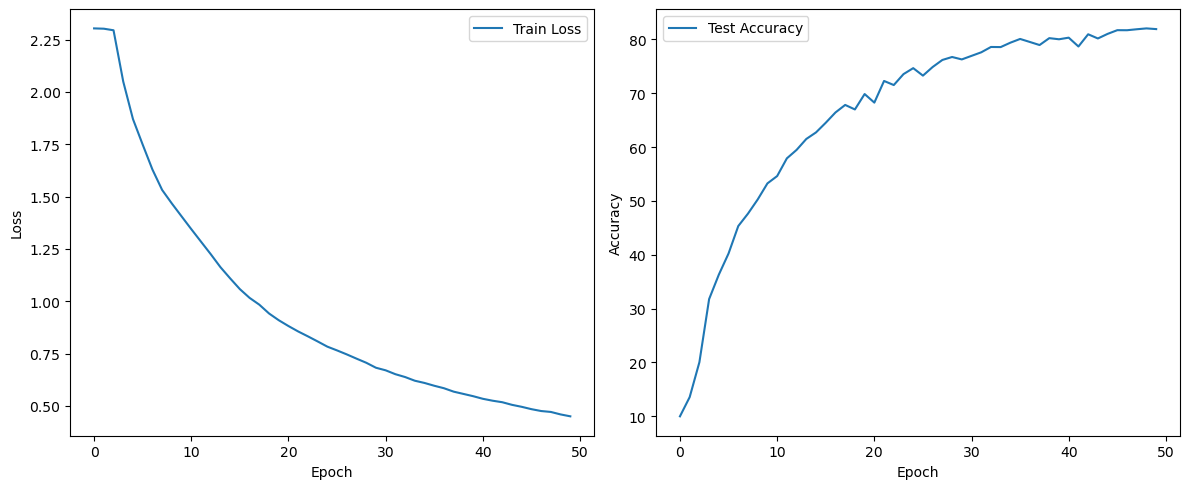

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the PyTorch model without Dropout
class Cifar10Model(nn.Module):
    def __init__(self):
        super(Cifar10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.pool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Initialize the model, optimizer with weight decay (L2 regularization), and loss function
model = Cifar10Model()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop with plotting
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
        print(f'Test Accuracy: {test_accuracy:.4f}%')
    
    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_plot.png')
    plt.show()

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50)


# Multiple regularization strategies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the PyTorch model with Dropout and Batch Normalization
class Cifar10Model(nn.Module):
    def __init__(self):
        super(Cifar10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.25)
        
        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn7(self.fc1(x)))
        x = self.dropout4(x)
        x = self.fc2(x)
        return x

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Initialize the model, optimizer with weight decay (L2 regularization), and loss function
model = Cifar10Model()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Training loop with plotting
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100):
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
        print(f'Test Accuracy: {test_accuracy:.4f}%')
        
        # Step the scheduler
        scheduler.step()
    
    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_plot.png')
    plt.show()

In [10]:
model = Cifar10Model()
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 10

In [8]:
fit(model, train_loader, Loss, optimizer, n_epochs)

[Epoch 1, Batch 100] loss: 2.304
[Epoch 1, Batch 200] loss: 2.303
[Epoch 1, Batch 300] loss: 2.304
[Epoch 1, Batch 400] loss: 2.303
[Epoch 1, Batch 500] loss: 2.303
[Epoch 1, Batch 600] loss: 2.303
[Epoch 1, Batch 700] loss: 2.302
[Epoch 2, Batch 100] loss: 2.303
[Epoch 2, Batch 200] loss: 2.302
[Epoch 2, Batch 300] loss: 2.302
[Epoch 2, Batch 400] loss: 2.302
[Epoch 2, Batch 500] loss: 2.302
[Epoch 2, Batch 600] loss: 2.302
[Epoch 2, Batch 700] loss: 2.302
[Epoch 3, Batch 100] loss: 2.302
[Epoch 3, Batch 200] loss: 2.302
[Epoch 3, Batch 300] loss: 2.301
[Epoch 3, Batch 400] loss: 2.301
[Epoch 3, Batch 500] loss: 2.301
[Epoch 3, Batch 600] loss: 2.300
[Epoch 3, Batch 700] loss: 2.300
[Epoch 4, Batch 100] loss: 2.297
[Epoch 4, Batch 200] loss: 2.295
[Epoch 4, Batch 300] loss: 2.291
[Epoch 4, Batch 400] loss: 2.280
[Epoch 4, Batch 500] loss: 2.255
[Epoch 4, Batch 600] loss: 2.221
[Epoch 4, Batch 700] loss: 2.172
[Epoch 5, Batch 100] loss: 2.121
[Epoch 5, Batch 200] loss: 2.077
[Epoch 5, 

# VGG network architecture As a ResNet

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/100, Loss: 1.5188
Test Accuracy: 55.0500%
Epoch 2/100, Loss: 1.1143
Test Accuracy: 59.9100%
Epoch 3/100, Loss: 0.9374
Test Accuracy: 67.4100%
Epoch 4/100, Loss: 0.8393
Test Accuracy: 68.0700%
Epoch 5/100, Loss: 0.7588
Test Accuracy: 72.3300%
Epoch 6/100, Loss: 0.7022
Test Accuracy: 74.4200%
Epoch 7/100, Loss: 0.6451
Test Accuracy: 76.0700%
Epoch 8/100, Loss: 0.6070
Test Accuracy: 78.5800%
Epoch 9/100, Loss: 0.5754
Test Accuracy: 78.4000%
Epoch 10/100, Loss: 0.5498
Test Accuracy: 80.1200%
Epoch 11/100, Loss: 0.5274
Test Accuracy: 78.9400%
Epoch 12/100, Loss: 0.5041
Test Accuracy: 81.5500%
Epoch 13/100, Loss: 0.4849
Test Accuracy: 80.5800%
Epoch 14/100, Loss: 0.4657
Test Accuracy: 82.5000%
Epoch 15/100, Loss: 0.4565
Test Accuracy: 82.3400%
Epoch 16/100, Loss: 0.4438
Test Accuracy: 80.8600%
Epoch 17/100, Loss: 0.4248
Test Accuracy: 82.1900%
Epoch 18/100, Loss: 0.4162
Test Accuracy: 83.1300%
Epoch 19/100, L

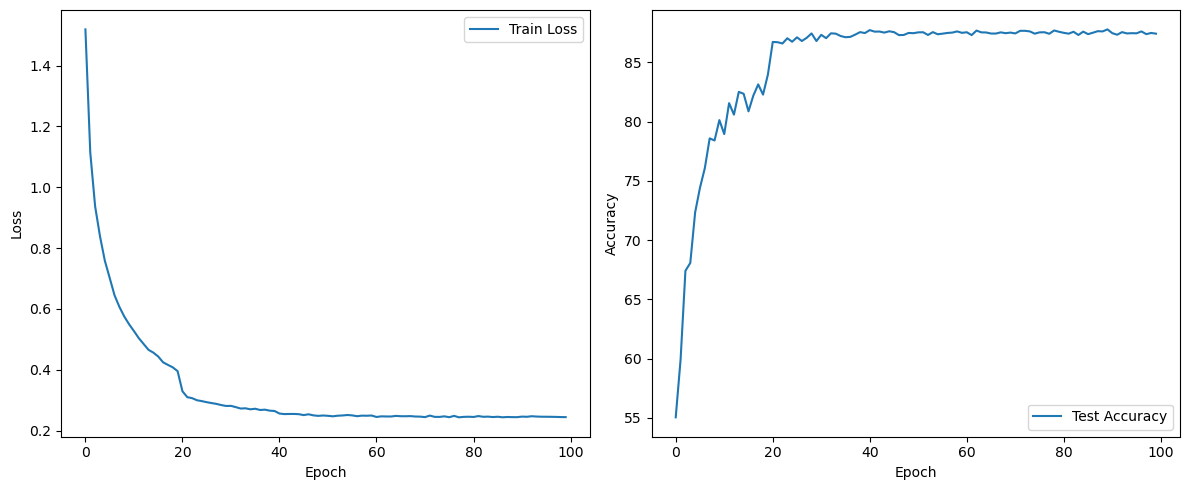

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the ResNet-like model with Skip Connections and Global Average Pooling
class ResNetCifar10(nn.Module):
    def __init__(self):
        super(ResNetCifar10, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
        
        # Skip connections
        self.skip_conv1 = nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0)
        self.skip_conv2 = nn.Conv2d(32, 64, kernel_size=1, stride=2, padding=0)
        self.skip_conv3 = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)) + self.skip_conv1(x))  # Match dimensions with skip_conv1
        
        residual = x
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)) + self.skip_conv2(residual))  # Match dimensions with skip_conv2
        
        residual = x
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)) + self.skip_conv3(residual))  # Match dimensions with skip_conv3
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Data preprocessing and augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Initialize the model, optimizer with weight decay (L2 regularization), and loss function
model = ResNetCifar10()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()

# Training loop with plotting
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100):
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
        print(f'Test Accuracy: {test_accuracy:.4f}%')
        
        # Step the scheduler
        scheduler.step()
    
    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_plot_resnet.png')
    plt.show()

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=100)


# VGG network architecture As a ResNet using Data Augmentation with 50 epoch 

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Loss: 1.9840
Test Accuracy: 43.9800%
Epoch 2/50, Loss: 1.8115
Test Accuracy: 56.9300%
Epoch 3/50, Loss: 1.7503
Test Accuracy: 60.6000%
Epoch 4/50, Loss: 1.6889
Test Accuracy: 63.0400%
Epoch 5/50, Loss: 1.6675
Test Accuracy: 63.2800%
Epoch 6/50, Loss: 1.6367
Test Accuracy: 64.4800%
Epoch 7/50, Loss: 1.6036
Test Accuracy: 70.2200%
Epoch 8/50, Loss: 1.5836
Test Accuracy: 72.4000%
Epoch 9/50, Loss: 1.5539
Test Accuracy: 72.1000%
Epoch 10/50, Loss: 1.5656
Test Accuracy: 70.9100%
Epoch 11/50, Loss: 1.5638
Test Accuracy: 73.8000%
Epoch 12/50, Loss: 1.5334
Test Accuracy: 74.3500%
Epoch 13/50, Loss: 1.5279
Test Accuracy: 73.1700%
Epoch 14/50, Loss: 1.5358
Test Accuracy: 74.9500%
Epoch 15/50, Loss: 1.5040
Test Accuracy: 73.3500%
Epoch 16/50, Loss: 1.5145
Test Accuracy: 74.6900%
Epoch 17/50, Loss: 1.5019
Test Accuracy: 77.7800%
Epoch 18/50, Loss: 1.5007
Test Accuracy: 72.4800%
Epoch 19/50, Loss: 1.5074
Test Ac

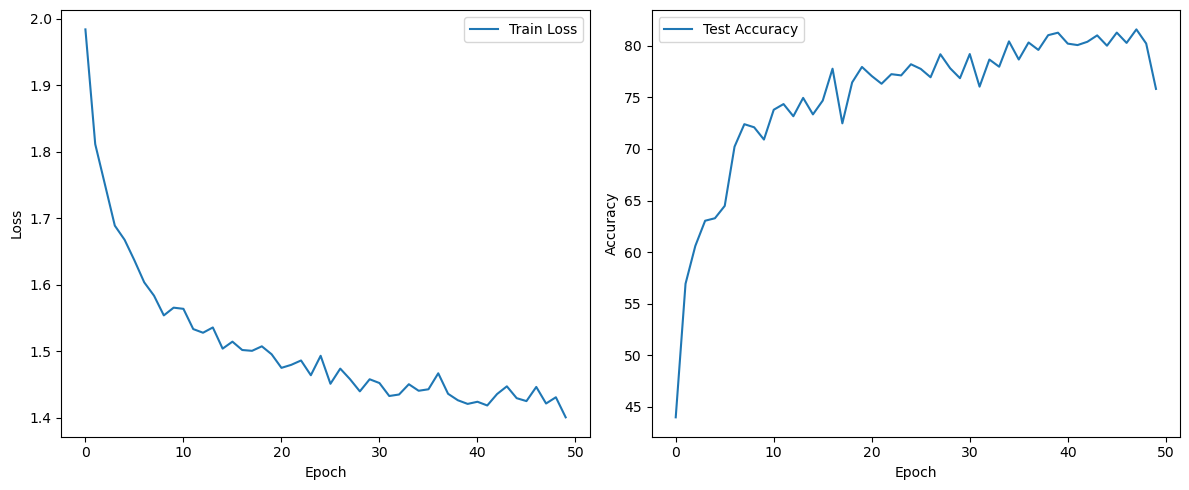

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the ResNet-like model with Skip Connections and Global Average Pooling
class ResNetCifar10(nn.Module):
    def __init__(self):
        super(ResNetCifar10, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
        
        # Skip connections
        self.skip_conv1 = nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0)
        self.skip_conv2 = nn.Conv2d(32, 64, kernel_size=1, stride=2, padding=0)
        self.skip_conv3 = nn.Conv2d(64, 128, kernel_size=1, stride=2, padding=0)

    def forward(self, x):
        residual = x
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)) + self.skip_conv1(x))  # Match dimensions with skip_conv1
        
        residual = x
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)) + self.skip_conv2(residual))  # Match dimensions with skip_conv2
        
        residual = x
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.relu(self.bn6(self.conv6(x)) + self.skip_conv3(residual))  # Match dimensions with skip_conv3
        
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Data preprocessing and extensive augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Initialize the model, optimizer with weight decay (L2 regularization), and loss function
model = ResNetCifar10()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# CutMix function
def cutmix_data(x, y, alpha=1.0):
    indices = torch.randperm(x.size(0))
    shuffled_x = x[indices]
    shuffled_y = y[indices]
    lam = np.random.beta(alpha, alpha)

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = shuffled_x[:, :, bbx1:bbx2, bby1:bby2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, y, shuffled_y, lam

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# MixUp function
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# Training loop with CutMix and MixUp
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            if np.random.rand() < 0.5:
                inputs, labels_a, labels_b, lam = cutmix_data(inputs, labels)
                outputs = model(inputs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            else:
                inputs, labels_a, labels_b, lam = mixup_data(inputs, labels)
                outputs = model(inputs)
                loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        
        # Evaluate on test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_accuracy = 100 * correct / total
        test_accuracies.append(test_accuracy)
        print(f'Test Accuracy: {test_accuracy:.4f}%')
    
    # Plotting loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_plot_resnet.png')
    plt.show()

# Train the model
if __name__ == '__main__':
    train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50)


In [11]:
evaluate_model(model, test_loader)

Accuracy on the test set: 9.71%


#### Baseline + Dropout

In [ ]:
model = Cifar10Model(dropout_rate=0.2, batch_norm=False)
Loss = nn.CrossEntropyLoss()
optimizer = create_optimizer(model, lr=0.001, momentum=0.9, weight_decay=0)
n_epochs = 10

In [ ]:
fit(model, train_loader, Loss, optimizer, n_epochs)

In [ ]:
evaluate_model(model, test_loader)

#### Baseline + Weight Decay (L2)

In [ ]:
model = Cifar10Model(dropout_rate=0, batch_norm=False)
Loss = nn.CrossEntropyLoss()
optimizer = create_optimizer(model, lr=0.001, momentum=0.9, weight_decay=0.0005)
n_epochs = 10

In [ ]:
fit(model, train_loader, Loss, optimizer, n_epochs)

In [ ]:
evaluate_model(model, test_loader)

#### Baseline + Data Augmentation( horizontal flipping + translation)

Load data with augmentation settings

In [ ]:
# mu = (0.4914, 0.4822, 0.4465)
# std=(0.2023, 0.1994, 0.2010)
#random_crop = 32 # crop size
horizontal_flip = 0.5 # random flip probability
translation = (0.1,0.1) # horizontal, vertical
batch_size = 64

train_transform = get_transforms(standardNormalize=True,horizontal_flip = horizontal_flip, translation = translation) # Parameters are defaulted to no change. change parameters as wanted
test_transform = get_transforms(standardNormalize=True)

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
model = Cifar10Model(dropout_rate=0, batch_norm=False)
Loss = nn.CrossEntropyLoss()
optimizer = create_optimizer(model, lr=0.001, momentum=0.9, weight_decay=0.0000)
n_epochs = 10

In [ ]:
fit(model, train_loader, Loss, optimizer, n_epochs)

In [ ]:
evaluate_model(model, test_loader)

## C Part

CutMix and MixUp functions

In [ ]:
# mu = (0.4914, 0.4822, 0.4465)
# std=(0.2023, 0.1994, 0.2010)
#random_crop = 32 # crop size
horizontal_flip = 0.5 # random flip probability
translation = (0.1,0.1) # horizontal, vertical

batch_size = 64

train_transform = get_transforms(standardNormalize=True,horizontal_flip = horizontal_flip, translation = translation) # Parameters are defaulted to no change. change parameters as wanted
test_transform = get_transforms(standardNormalize=True)

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, pin_memory=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, pin_memory=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
model = Cifar10Model(dropout_rate=0, batch_norm=False)
Loss = nn.CrossEntropyLoss()
optimizer = create_optimizer(model, lr=0.001, momentum=0.9, weight_decay=0.0000)
n_epochs = 10

In [ ]:
fit(model, train_loader, Loss, optimizer, n_epochs, CutMix = True) # can test with MixUp

In [ ]:
evaluate_model(model, test_loader)